In [48]:
import pickle
import numpy as np
import pandas as pd

from config import config

In [49]:
# Directory where the csv files and /center, /left /right directories are located.
data_dir = config['bag4']
# Pickle file with 'image', 'steer_pred', 'steer_label' data outputted by pilot_net.py
file_name = r'predictions.pickle'

with open(file_name, 'rb') as f:
    data = pickle.load(f)

In [50]:
data_list = ['image', 'steer_pred', 'steer_label']

# The raw data is of length 7, with each containing 32 data point.
# 32 is the size of the mini-batch when training in this case
reformat = lambda x: np.concatenate(np.array(data[x]))#.reshape(7,))

# Reformat each data point.
for key in data_list:
    data[key] = reformat(key)

In [51]:
data['image'].shape

(197,)

In [52]:
import tensorflow as tf

def image_aug_fn(data, data_dir):
    # Create function that creates iterator with data set.
    # Since image was saved as a path, we need to convert image path to
    # actual image. 
    def _convert_image(data_set):
        path = data_dir + data_set['image']
        x = tf.to_float(tf.image.decode_image(tf.read_file(path)))
        x = x / 255.0
        x.set_shape([480,640,3])
  
        x = tf.image.random_brightness(x,max_delta=32./255.)
        x = tf.image.random_contrast(x,lower=0.2,upper=1.5)
        x = tf.image.random_hue(x, max_delta=0.2)
        x = tf.clip_by_value(x, 0.0, 1.0)

        data_set['image'] = tf.image.resize_image_with_crop_or_pad(
            x,
            150,
            480,
        )

        return data_set
    
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.map(_convert_image)
    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    return next_element


In [53]:
next_element = image_aug_fn(data, data_dir)

In [54]:
with tf.Session() as sess:
    img0 = sess.run(next_element)
    img1 = sess.run(next_element)
    img2 = sess.run(next_element)


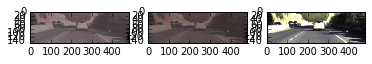

In [55]:
import matplotlib.pylab as plt
%matplotlib inline
plt.figure()
plt.subplot(231)
plt.imshow(img0['image'])
plt.subplot(232)
plt.imshow(img1['image'])
plt.subplot(233)
plt.imshow(img2['image'])
